In [2]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer
from sklearn.ensemble import RandomForestClassifier

import eli5

Our target variable is Adoption Speed:

0 - Pet was adopted the day it was listed.

1 - Pet was adopted the first week after being listed.

2 - Pet was adopted the first month after being listed.

3 - Pet was adopted in the 2nd and 3rd month after being listed.

4 - The pet hasn't been adopted 90 days after being listed. :( 


In [3]:
# Reading in all our data

train = pd.read_csv("data/train/train.csv")
breeds = pd.read_csv("data/breed_labels.csv")
colours = pd.read_csv("data/color_labels.csv")
states = pd.read_csv("data/state_labels.csv")

test = pd.read_csv("data/test/test.csv")
submission = pd.read_csv("data/test/sample_submission.csv")

# Add the type of dataset
train["DataType"] = "training_data"
test["DataType"] = "testing_data"


all_data = pd.concat([train, test])

# Data Analysis

In [4]:
# train.drop(labels = ["Description"], axis = 1, inplace=True) # Can add other labels to drop later if necessary
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 25 columns):
Type             14993 non-null int64
Name             13736 non-null object
Age              14993 non-null int64
Breed1           14993 non-null int64
Breed2           14993 non-null int64
Gender           14993 non-null int64
Color1           14993 non-null int64
Color2           14993 non-null int64
Color3           14993 non-null int64
MaturitySize     14993 non-null int64
FurLength        14993 non-null int64
Vaccinated       14993 non-null int64
Dewormed         14993 non-null int64
Sterilized       14993 non-null int64
Health           14993 non-null int64
Quantity         14993 non-null int64
Fee              14993 non-null int64
State            14993 non-null int64
RescuerID        14993 non-null object
VideoAmt         14993 non-null int64
Description      14981 non-null object
PetID            14993 non-null object
PhotoAmt         14993 non-null float64
AdoptionSpe

Looking at the initial data analysis, we see that there are a lot of names missing - which poses the question of how naming influences adoption speed?
We also see that there is a Breed1 and Breed2 feature, where Breed2 is 0 when the animal is purebred.
We can also look at how the photo and video amounts influence adoption speed, as well vaccination, sterilization etc.

## Now lets get into it ...

Text(0.5,1,'Count of Adoption Speed Classes')

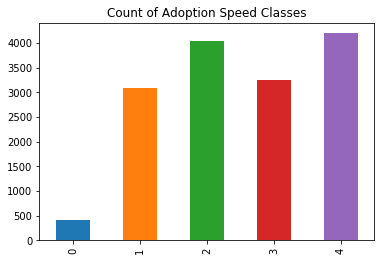

In [5]:
all_data["AdoptionSpeed"].value_counts().sort_index().plot("bar")
plt.title("Count of Adoption Speed Classes")

We can see from the graph above that even though some animals get adopted on the same day,a lot more get edopted in the first week or two. Sadly the class with the highest counts are animals who still aren't adoped.

## Dogs vs Cats

Text(0.5,1,'Number of dogs and cats in the train and test set: ')

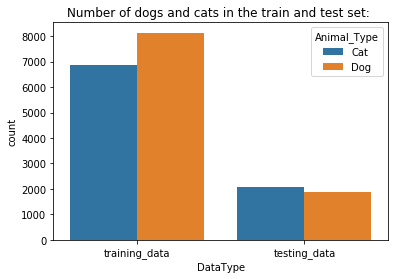

In [6]:
all_data["Animal_Type"] = ["Dog" if x == 1 else "Cat" for x in all_data["Type"]]
sns.countplot(x="DataType", data = all_data, hue="Animal_Type")
plt.title("Number of dogs and cats in the train and test set: ")

So we can see there is an insignificant difference in the dog:cat ratio in the different data sets.

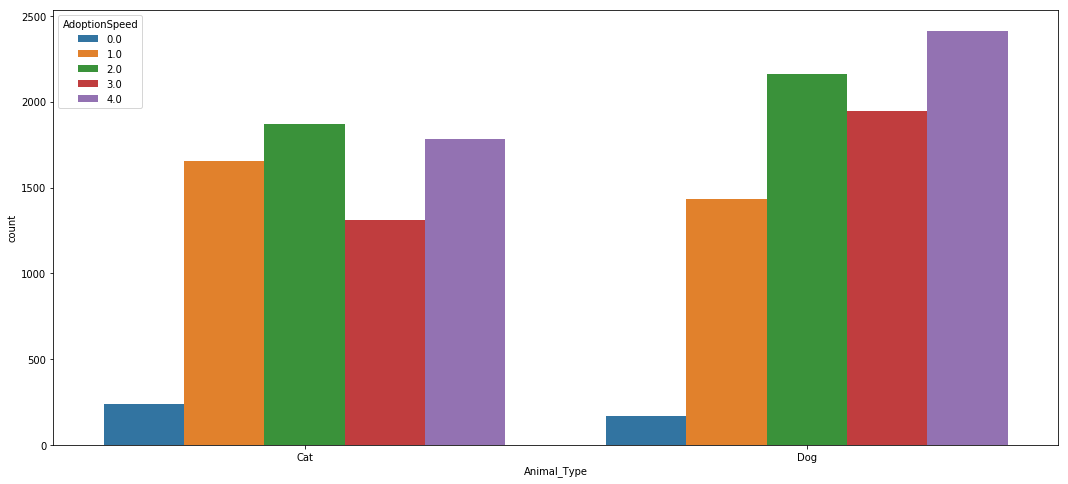

In [7]:
plt.figure(figsize=(18, 8))
sns.countplot(x = "Animal_Type", hue="AdoptionSpeed", data = all_data)

Cats are more likely to get adopted early on, where more dogs get adopted later. We can also see that the overall percentage of cats that are not adopted is lower than for dogs.

## Do the names they give the pets have an influence?

In [8]:
print("Most popular pet names and AdoptionSpeed:")
for n in all_data["Name"].value_counts().index[:5]:
    print(n)
    print(all_data.loc[all_data["Name"] == n, "AdoptionSpeed"].value_counts().sort_index(),"\n")

Most popular pet names and AdoptionSpeed:
Baby
0     2
1    11
2    15
3    11
4    27
Name: AdoptionSpeed, dtype: int64 

Lucky
0     5
1    14
2    16
3    12
4    17
Name: AdoptionSpeed, dtype: int64 

No Name
0     3
1    14
2    11
3     6
4    20
Name: AdoptionSpeed, dtype: int64 

Brownie
0     1
1    11
2    14
3    12
4    16
Name: AdoptionSpeed, dtype: int64 

Mimi
0     3
1    12
2    13
3     7
4    17
Name: AdoptionSpeed, dtype: int64 



In [9]:
print("No Name: ", all_data[all_data["Name"] == "No Name"]["Name"].count())
print("Unnamed: ", all_data[all_data["Name"] == "Unnamed"]["Name"].count())
print("None: ", all_data[all_data["Name"] == "None"]["Name"].count())
print("No Name Yet: ", all_data[all_data["Name"] == "No Name Yet"]["Name"].count())

No Name:  66
Unnamed:  5
None:  9
No Name Yet:  26


In [10]:
all_data["Name"] = all_data["Name"].fillna("Unnamed")

all_data["Name"] = np.where(all_data["Name"] == "No Name","Unnamed", all_data["Name"])
all_data["Name"] = np.where(all_data["Name"] == "None","Unnamed", all_data["Name"])
all_data["Name"] = np.where(all_data["Name"] == "No Name Yet","Unnamed", all_data["Name"])

Let's create a feature based on whether the animal has a name or not, and then we can compare the adoption speed to named animals.

In [11]:
all_data["Unnamed"] = 0
all_data.loc[all_data["Name"] == "Unnamed", "Unnamed"] = 1

In [12]:
pd.crosstab(all_data["Unnamed"], all_data["AdoptionSpeed"], normalize = "index")

AdoptionSpeed,0,1,2,3,4
Unnamed,,,,,
0,0.027845,0.205027,0.271342,0.221954,0.273833
1,0.022288,0.216939,0.248143,0.170877,0.341753


It seems that if an animal is unnamed, it less likely to get adopted compared to an animal with an assigned name.

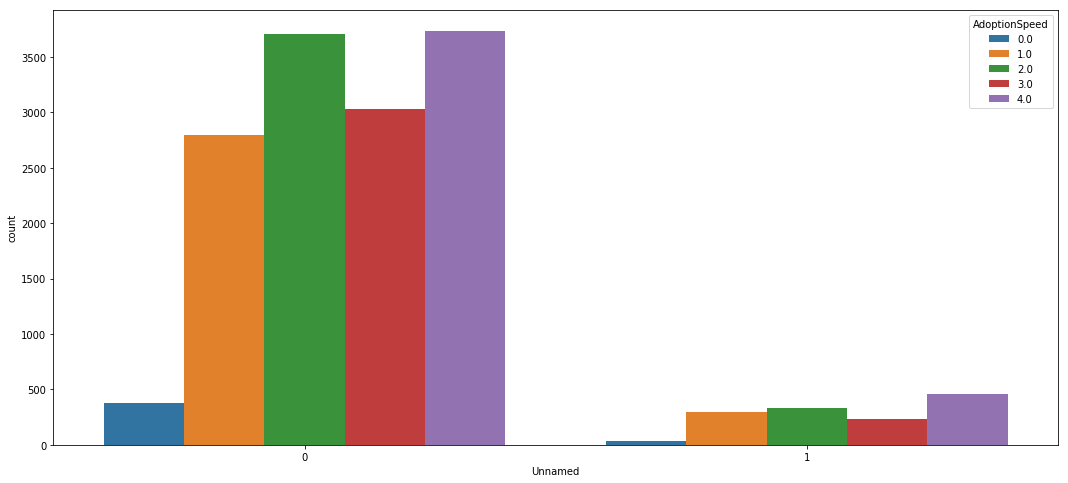

In [13]:
plt.figure(figsize=(18,8))
sns.countplot(x = "Unnamed", hue="AdoptionSpeed", data=all_data)

In [14]:
all_data[all_data["Name"].apply(lambda x: len(str(x))) <= 3]["Name"].value_counts()

Max    48
Tom    33
Boy    20
Leo    18
Ben    15
Sam    14
Mia    10
QQ     10
Ash    10
Sky     9
BB      9
Rex     8
Blu     8
Joe     8
Dot     7
Amy     6
Joy     6
May     6
MJ      6
JJ      6
Eva     5
B1      5
Zoe     5
Jay     5
Bee     5
A1      4
Don     4
B2      4
Ace     4
Tux     4
       ..
Mi      1
A88     1
CC      1
AB      1
KAT     1
KD      1
W2      1
Py      1
Dow     1
C.C     1
R11     1
Iko     1
KIT     1
Bim     1
Any     1
Mix     1
L17     1
Eli     1
Low     1
TIA     1
A6      1
C4C     1
G2      1
DJ      1
NIL     1
Ivy     1
Qu      1
F34     1
BB2     1
D7      1
Name: Name, Length: 442, dtype: int64

So we see that some of the names that have 3 characters or less are meaningless. This then probably increases the animals chances of not getting adopted, but we can't remove all these names since names like Max and Tom do have meaning.

## Does age matter? 

I would expect that people are more likely to adopt puppies and kittens than older animals. But let's take a look ...

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021C5DA34208>]],
      dtype=object)

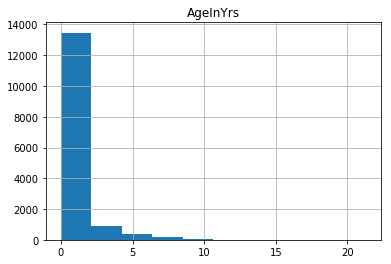

In [15]:
# Currently the age is in months so I want to set it to age in years
all_data["AgeInYrs"] = all_data["Age"]/12
all_data["AgeInYrs"] = all_data["Age"]/12

all_data.hist(column = "AgeInYrs")

It seems that the majority of animals are under the age of 3

Let's now analyse the adoption speed based on age.

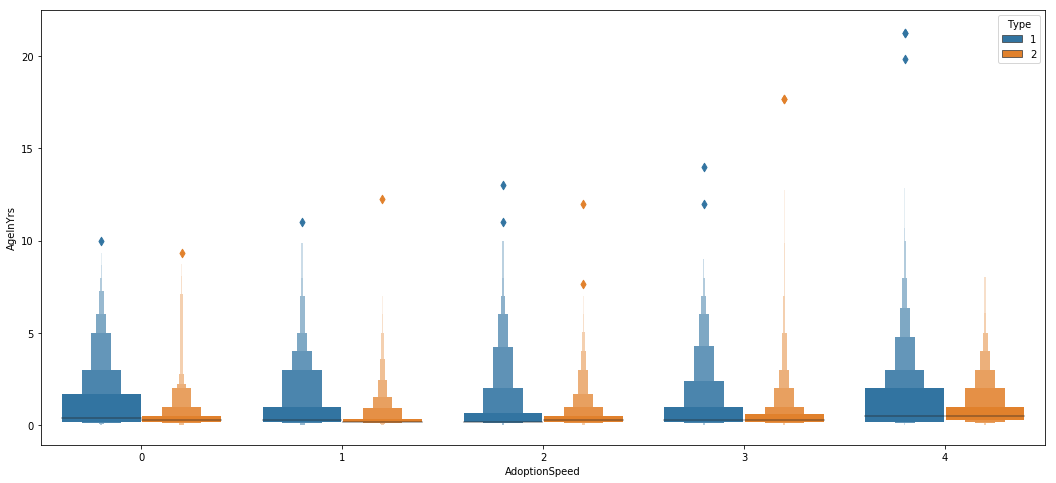

In [16]:
plt.figure(figsize=(18,8))
ax = sns.boxenplot(x = "AdoptionSpeed", y="AgeInYrs", hue="Animal_Type", data=all_data)

Looking at the graph above, we can see that younger pets are adopted a lot more quickly than older pets. 

## Breeds: Mixed vs Pure? 

I'm wondering if people are more likely to adopts a pure breed animal or a mixed breed animal?

In [17]:
all_data["MixedBreed"] = [1 if x > 0 else 0 for x in all_data["Breed2"]]

So it seems that the majority of animals are pure bred which is unexpected.

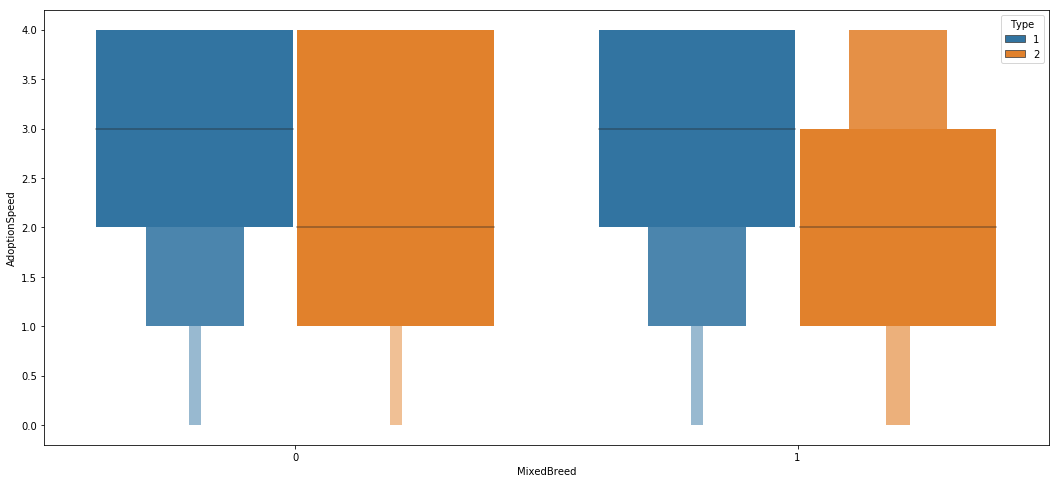

In [20]:
plt.figure(figsize=(18,8))
sns.boxenplot(x = "MixedBreed", y = "AdoptionSpeed", hue="Animal_Type", data=all_data)

So it seems that dogs have an equally likely chance of being adopted for both mixed and pure breeds. For cats, mixed breed cats are more likely to be adopted quickly than pure breed cats.

Let's try to see whether a specific breed is more likely to be adopted.

In [21]:
breeds.head()

,BreedID,Type,BreedName
0,1,1,Affenpinscher
1,2,1,Afghan Hound
2,3,1,Airedale Terrier
3,4,1,Akbash
4,5,1,Akita


In [22]:
breed_cols = breeds[["BreedID", "BreedName"]]

breed_cols.set_index("BreedID", drop = True, inplace = True)

breed_dict = breed_cols.to_dict()["BreedName"]

In [23]:
all_data.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,DataType,Unnamed,AgeInYrs,MixedBreed
0,2,Nibble,3,299,0,1,1,7,0,1,...,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2,training_data,0,0.250000,0
1,2,Unnamed,1,265,0,1,1,2,0,2,...,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0,training_data,1,0.083333,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3,training_data,0,0.083333,0
3,1,Miko,4,307,0,2,1,2,0,2,...,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2,training_data,0,0.333333,0
4,1,Hunter,1,307,0,1,1,0,0,2,...,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2,training_data,0,0.083333,0


In [24]:
all_data["Breed1"] = all_data["Breed1"].map(breed_dict).fillna("Unknown")
all_data["Breed2"] = all_data["Breed2"].map(breed_dict).fillna("None")

We see that even though some of the breed names doesn't count as a pure breed, such as "Mixed Breed".

In [25]:
(all_data["Breed1"] + " & " + all_data["Breed2"]).value_counts().head()

Mixed Breed & None             5573
Domestic Short Hair & None     4042
Domestic Medium Hair & None    1264
Mixed Breed & Mixed Breed      1188
Tabby & None                    379
dtype: int64

In some cases people write both the breeds in the second field, even though its the same as the first. So how do we go about using breed information if we have inaccurate data?

I decided that I'm going to list them as mixed breed if mixed breed is present in the column.

Also, for some of the cases of catsthe same breed is listed twice and they're then seen as mixed breed.
We also notice that domestic short/medium/long hair cats are seen as pure bred, but they're not recognised as a pure breed so we need to adjust this.

In [26]:
all_data[["Breed1", "Breed2", "MixedBreed"]].head()

,Breed1,Breed2,MixedBreed
0,Tabby,None,0
1,Domestic Medium Hair,None,0
2,Mixed Breed,None,0
3,Mixed Breed,None,0
4,Mixed Breed,None,0


In [27]:
# Make all the cases pure bred if breed 1 is the same as breed 2
all_data.loc[all_data["Breed1"] == all_data["Breed2"], "MixedBreed"] = 0

# But for the following cases, they are mixed:
all_data.loc[all_data["Breed1"] == "Mixed Breed", "MixedBreed"] = 1
all_data.loc[all_data["Breed1"] == "Domestic Short Hair", "MixedBreed"] = 1
all_data.loc[all_data["Breed1"] == "Domestic Medium Hair", "MixedBreed"] = 1
all_data.loc[all_data["Breed1"] == "Domestic Long Hair", "MixedBreed"] = 1

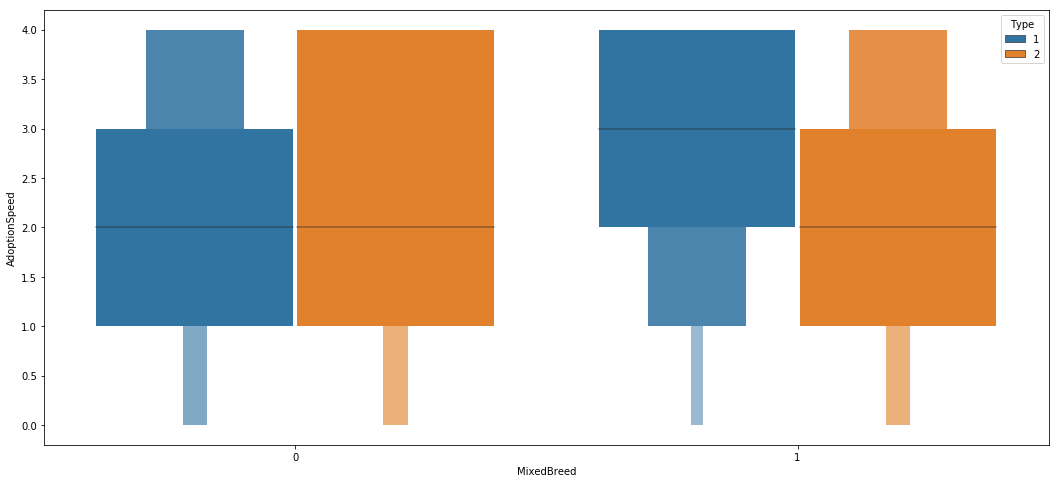

In [28]:
plt.figure(figsize=(18,8))
sns.boxenplot(x = "MixedBreed", y = "AdoptionSpeed", hue="Animal_Type", data=all_data)

Now we have a better idea of the adoption rates of mixed breed animals. We can see that pure bred dogs get adopted faster than mixed breed dogs.

But cats get adopted faster when they're a mixed breed.

We will now use the "MixedBreed" feature instead of "Breed1" and "Breed2".

## Gender

Note that 1 - Male, 2 - Female and 3 - Mixed (Like when the profile represents multiple pets).

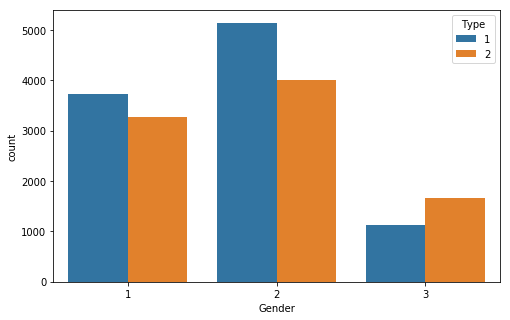

In [29]:
plt.figure(figsize=(8,5))
sns.countplot(x = "Gender", hue="Animal_Type", data=all_data)

So we can see that there are a lot more female pets in the shelter than males. The smallest group is the mised gender group.

Now let's look at the distribution of the adoption speed of these different groups.

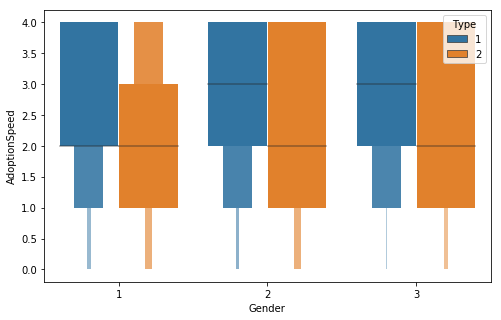

In [30]:
plt.figure(figsize=(8,5))
sns.boxenplot(x = "Gender", y = "AdoptionSpeed", hue="Animal_Type", data=all_data)

Male dogs get adopted a lot faster than female dogs and male cats tend to get adopted and not stay at the shelter for longer than 90 days unlike female cats.
Female dogs on average get adopted later than male dogs, and a lot of of them don't get adopted.
The mixed groups have similar distributions than the female dog and cat groups, except they tend to not get adopted as early.
Does the mixed group mostly consist of a mother and her babies? And how many animals normally fall in the gender category 3?

In [31]:
all_data[all_data["Gender"] == 3]["Quantity"].describe()

count    2791.000000
mean        3.910068
std         2.298389
min         2.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        20.000000
Name: Quantity, dtype: float64

On average, there are 4 animals that are listed as a group to be adopted. There's even a case of 20 animals. Normally, people adopt one or two pets so this explains the undesired adoption speed for this group. Shelters should consider listing the animals in smaller groups, or finding forster homes for them until the babies are weaned off their mom.

But let's look at the description of these animals to investigate more.

## Description 

In [38]:
all_data['Quantity'].value_counts().head(20)

1     14564
2      1823
3       905
4       678
5       443
6       222
7       109
8        69
9        44
10       26
20       18
11       12
12        7
15        6
14        4
17        3
13        3
16        3
18        2
Name: Quantity, dtype: int64

In [48]:
pd.set_option('max_colwidth', 800)
all_data.loc[all_data['Quantity'] > 19][['Description', 'Quantity', 'AdoptionSpeed']].head(20)

,Description,Quantity,AdoptionSpeed
263,"These are 20 puppies, from 2 stray mums need good homes. They are 2 weeks old. If you can give them a good home without caging or chaining, please whatsapp or msg Ms Grace Bong tel no:",20,4.0
427,"Hi, kepada sesiapa yang berminat untuk adopt kucing-kucing sila hubungi saya . Di sini ada berbagai jenis kucing, dari short hair - long hair.",20,4.0
1305,Bailey is an obedient and loyal dog Her owner is terminaaly ill and is unable to care for her,20,4.0
1659,"Hi feline lovers, There are 40 cats desperately seeking new homes before they are taken away from DBKL! This video link shows the lady who has been keeping these cats: Her neighbors seem to dislike cats, so they complained to DBKL. DBKL came to her house and told her to get rid of those cats. They'll be coming back to her house this Monday (6th February ) and she can only have 1 cat. DBKL will take the other cats and put them to sleep. She's looking for people who wants to adopt her cats and be their new owner. If you are interested, please contact Nicole at. Thank you.",20,2.0
4759,"The owner of these babies (Makcik Ani) has passed away on Monday 3 July There are about 30 cats. Mostly rescued. Her husband (Pakcik Ali) cannot manage 30 cats all alone by himself as he is old already. All cats are fully indoor T&C: New adopters must be able to care for the cats financially & care for them wholeheartedly with lots of love and with patience because Allahyarhamah Makcik Ani loved all her cats unconditionally. Location: Section 17, Shah Alam",20,2.0
6332,DAISY IS SMART AND LOYAL HER OWNER IS TERMINALLY ILL AND UNABLE TO CARE FOR HER,20,4.0
7094,SAYA ADA 20 LEBIH EKOR KUCING YANG TERPAKSA SAYA LEPASKAN SEBAB SAYA PERLU PINDAH TINGGAL DI KAMPUNG.Dalam gambar tu adalah separuh dari kucing yg saya ada.,20,4.0
7993,Iris owner is terminally ill and unable to care for her She is very approachable and caring in nature.,20,4.0
9405,Mocha is a lovable and friendly dog Owner is terminally ill and unable to care for her,20,4.0
9779,Sasha is obedient and has good temperament Her owner is terminally ill and is unable to care for her,20,4.0


It seems that some of the descriptions and the actual quantity listed is not always the same. Most of the pets that have a quantity of 20, seems to actually be one pet.

Let's see if the length of a description influences the adoption speed.

Text(0.5,1,'AdoptionSpeed by Type and count of words in description')

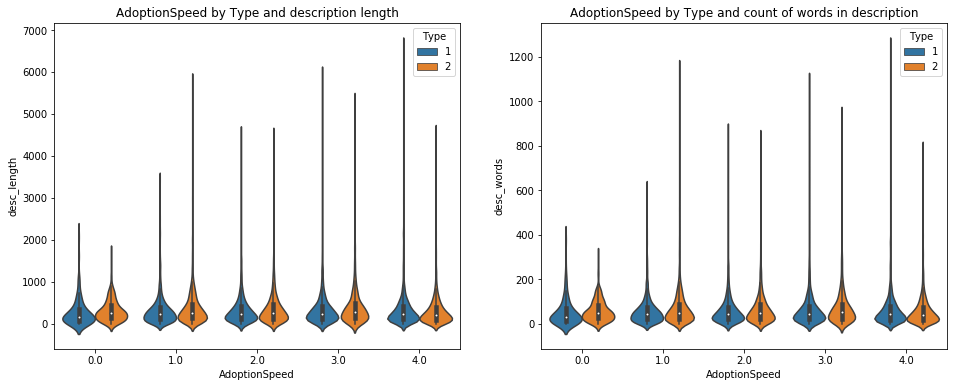

In [82]:
all_data["Description"] = all_data["Description"].fillna("")
all_data["desc_length"] = all_data["Description"].apply(lambda x: len(x))
all_data["desc_words"] = all_data["Description"].apply(lambda x: len(x.split()))

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.violinplot(x="AdoptionSpeed", y="desc_length", hue="Animal_Type", data=all_data)
plt.title("AdoptionSpeed by Type and description length")

plt.subplot(1, 2, 2)
sns.violinplot(x="AdoptionSpeed", y="desc_words", hue="Animal_Type", data=all_data)
plt.title("AdoptionSpeed by Type and count of words in description")

It seems that shorter descriptions lead to faster adoption, and especially on the case of dogs, the longer the description, the least likely to get adopted.

## Size of the pets 

Perhaps smaller dogs are more likely to get adopted, since larger dogs need more space. I would think size doesn't really matter when it comes to cats, but let's check it out.

Maturity Sizes are 1 - Small, 2 - Medium, 3 - Large, 4 - Extra Large, 0 - Not Specified.

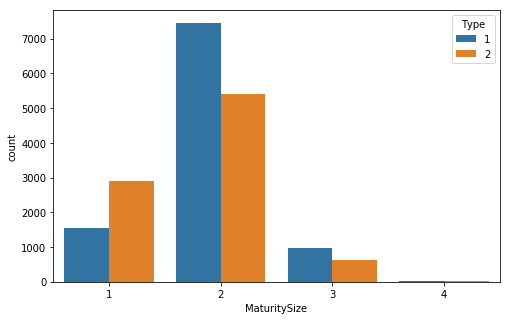

In [32]:
plt.figure(figsize=(8,5))
sns.countplot(x = "MaturitySize", hue = "Animal_Type", data = all_data)

Most dogs and cats are medium sized, and there aren't any cases where we have no data on the size. So let's check out the distribution.

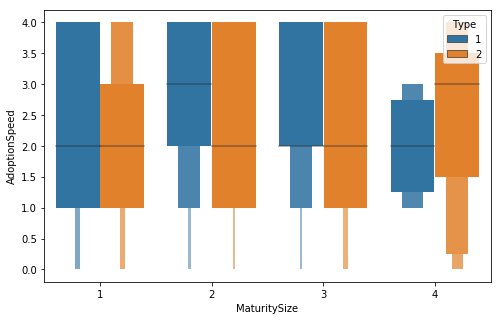

In [62]:
plt.figure(figsize=(8,5))
sns.boxenplot(x = "MaturitySize", y = "AdoptionSpeed", hue = "Animal_Type", data = all_data)

Looks like smaller dogs are adopted quicker than their larger counterparts, and small cats are definitely the most popular size.
It seems that there are no cases where the extra large dogs don't get adopted, so let's investigate that group and the unspecified size group.


In [63]:
all_data[all_data["MaturitySize"] == 0]

# There are no casesn where we don't have a maturity size (Yay!)

,AdoptionSpeed,Age,Breed1,Breed2,Color1,Color2,Color3,DataType,Description,Dewormed,...,Quantity,RescuerID,State,Sterilized,Type,Vaccinated,VideoAmt,Animal_Type,Unnamed,MixedBreed


In [64]:
all_data[all_data["MaturitySize"] == 4]

,AdoptionSpeed,Age,Breed1,Breed2,Color1,Color2,Color3,DataType,Description,Dewormed,...,Quantity,RescuerID,State,Sterilized,Type,Vaccinated,VideoAmt,Animal_Type,Unnamed,MixedBreed
1265,1.0,12,Great Dane,None,1,0,0,training_data,Oreo Female Great Dane 1 year old,1,...,1,b3b9d092e0cced7bb066e65e6793f527,41326,1,1,1,0,Dog,0,0
1899,2.0,36,Bullmastiff,Rottweiler,1,2,0,training_data,Ali (named after the boxer Mohammad Ali) has a...,1,...,1,aa66486163b6cbc25ea62a34b11c9b91,41326,2,1,1,0,Dog,0,1
2461,2.0,36,Saint Bernard,None,1,2,7,training_data,Owner bought him from a pet shop and was told ...,1,...,1,fa90fa5b1ee11c86938398b60abc32cb,41326,2,1,1,0,Dog,0,0
2514,2.0,4,Domestic Short Hair,None,1,6,0,training_data,-,2,...,1,5be13320d12dc6478d94268d6e103e56,41401,2,2,2,0,Cat,1,1
2523,3.0,72,Rottweiler,None,1,2,0,training_data,Rotti girl with MKA certificate looking for a ...,3,...,1,fa90fa5b1ee11c86938398b60abc32cb,41326,1,1,3,0,Dog,0,0
2738,1.0,18,Rottweiler,None,1,2,0,training_data,Pure breed Rottweiler rescued fr breeder. Alre...,1,...,1,fa90fa5b1ee11c86938398b60abc32cb,41326,1,1,1,0,Dog,0,0
3157,3.0,36,Golden Retriever,Mixed Breed,3,0,0,training_data,Owner cannot keep him anymore due to council r...,1,...,1,fa90fa5b1ee11c86938398b60abc32cb,41326,1,1,1,0,Dog,0,1
3558,2.0,13,Doberman Pinscher,None,1,2,0,training_data,"He is very playful, alert, energetic, smart an...",1,...,1,ac8608c9cc3c828c4b5a44a7e6002cbe,41326,2,1,1,0,Dog,0,0
4706,3.0,12,Great Dane,None,1,0,0,training_data,She is a pure Great Dane. Black in colour. I a...,1,...,1,64cab7e12961c2929700559615bc8488,41401,2,1,1,0,Dog,0,0
5571,0.0,1,Maine Coon,Bobtail,1,7,0,training_data,He is a very active and lovable kitten (about ...,1,...,1,3554aa44f8737bf17937be3b8231a79a,41401,2,2,2,2,Cat,0,1


I just saw that for same cases we have NaN's for the adoption speed, which is a problem. Do we rather set it as a 4? Or the average adoption speed?
I'll check how many cases have NaN's before I decide anything.

In [53]:
print(((len(all_data) - all_data["AdoptionSpeed"].count())/all_data["AdoptionSpeed"].count())*100)

26.332288401253916


So 26% of our adoption speeds are nulls. What I'm going to do is train the model on 3 cases: 

1) Fill NaN with highest adoption speed. 

2) Drop NaN records 

3) Fill in the average adoptionspeed

But for the data analysis, I'll drop the NA records.

In [61]:
all_data.dropna(axis=0, how = "any", inplace=True)

## Vaccinations and sterilisation

How does the pet being vaccinated and sterlised influence the adoption speed?

Vaccinations: 1-Yes, 2-No, 3-Unsure

Dewormed: 1-Yes, 2-No, 3-Unsure

Sterilised: 1-Yes, 2-No, 3-Unsure


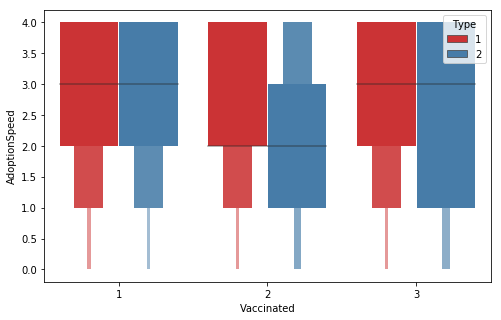

In [79]:
plt.figure(figsize=(8,5))
sns.boxenplot(x="Vaccinated", y="AdoptionSpeed", hue = "Animal_Type", data = all_data, palette="Set1")

It's strange how the adoption speed for animals that weren't vaccinated s smaller than those who have. Unsurity aboout the vaccination status of cats seem to negative influence adoption speed.

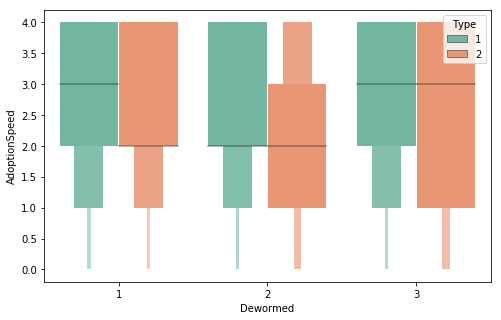

In [80]:
plt.figure(figsize=(8,5))
sns.boxenplot(x="Dewormed", y="AdoptionSpeed", hue = "Type", data = all_data, palette = "Set2")

It seems that dewormed animals have a similar distribution than those that were vaccinated. This is very strange - does this mean people prefer animals that weren't vaccinated or dewormed? Or is it a case of puppy or kittens being adopted, and just not being old enough for all the vaccinations?

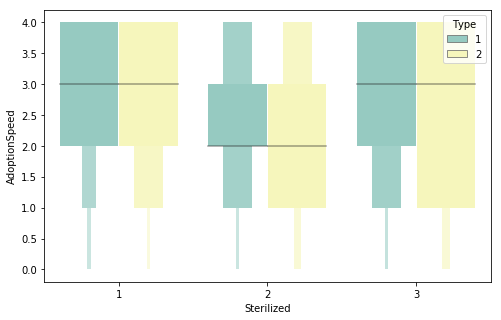

In [81]:
plt.figure(figsize=(8,5))
sns.boxenplot(x="Sterilized", y="AdoptionSpeed", hue = "Type", data = all_data, palette="Set3")

Seems like non-sterilised animals have a better change of being adopted - especially cats.

## What about health?

1 - Healthy

2 - Minor injury

3 - Serious injury

0 - Not specified

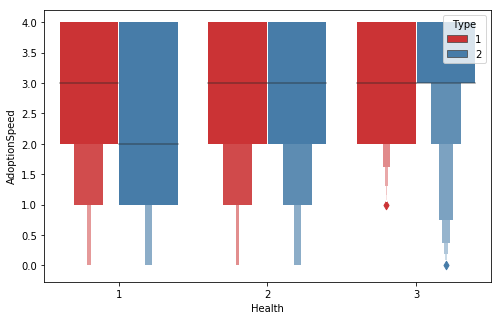

In [83]:
plt.figure(figsize=(8,5))
sns.boxenplot(x="Health", y="AdoptionSpeed", hue = "Type", data = all_data, palette="Set1")

Seems like pets with serious injuries are the least likely to be adopted in the early stages after they were listed.

## Adoption Fee


Now I'm trying to establish whether the adoption rate is influenced by the adoption fees. So let's look at the distribution of the fees.

In [54]:
all_data["Fee"].value_counts().head(30)

0      15863
50       600
100      543
200      301
150      245
20       159
300      152
250      146
30       132
1        104
10        92
80        80
500       70
350       66
400       39
15        33
5         27
120       23
40        22
60        18
600       15
70        15
450       13
25        13
180       13
160       11
90        10
45        10
8          9
550        7
Name: Fee, dtype: int64

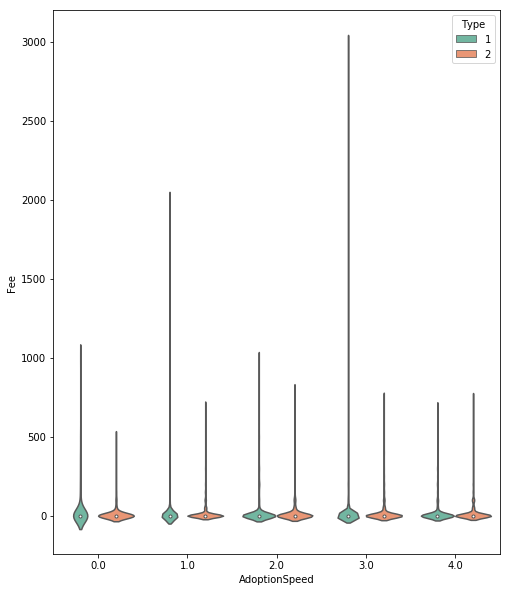

In [65]:
plt.figure(figsize=(8,10))
sns.violinplot(x = "AdoptionSpeed", y="Fee", hue = "Type", data = all_data, palette="Set2")

If we look at dogs, it seems that the fees range between 0 and 3 000. However, it seems that adoption speed 3 has the highest fees, whereas adoption speed 4 has the lowest fees. 

In the case of cats, there doesn't seem to be a significant difference in the fees for the different adoption speeds.